# **Analys The Problem**

Previously on papper "Facial Expression Recognition Methods in the Wild Based on Fusion Feature of Attention Mechanism and LBP (MDPI Sensors 2023 Q2)" authors used a model called ResNet-50 combined CBAM and LBP.

The accuracy took:
- 99.66% on CK+
- 74.23% on FER-2013
- 89.50 on FER-PLUS 
- 88.20 on RAF-DB

**The problem: What if I change the variant of LBP in this method, does it increase the accuracy spesifically for FER-2013 dataset?**

# **About Dataset**

- The paper used 4 dataset include CK+(59 images), FER-2013 (35,887 images), FER-PLUS(31.412 images), RAF-DB (29,672 images)
- CK+ is a controlled dataset and the 3 others datasets are uncontrolled datasets
- Controlled dataset has good lightning and pose but uncontrolled datasets got a random of it

# **Method**

## Paper's Method

- **ResNet-18 + CBAM**

    1. Architecture of ResNet-18:
    
        <img src="../src/Structure-of-a-ResNet-18-architecture.png" alt="Windowing of Feature in Faces" width="350" height="250">

    2. CBAM Architecture:

        <img src="../src/cbam.png" alt="Windowing of Feature in Faces" width="600" height="100">

    3. Authors combine the CBAM module into each block of the ResNet-18 architecture,
    
        Before and After implement the CBAM module:

        <img src="../src/oriblock.png" alt="Windowing of Feature in Faces" width="150" height="200">
        <img src="../src/blocknCbam.png" alt="Windowing of Feature in Faces" width="150" height="200">

- **Local Binary Patterns (LBP)**

    LBP is one of the most generally used texture pattern descriptors for examining local grain features and is regarded as one of the best methods for texture processing, which is widely employed in image processing.

- **RCL-Net Model**

    After combining all the method such as LBP and ResNet-CBAM, this architecture called by **RCL-Net Model**,

    <img src="../src/rcl-net.png" alt="Windowing of Feature in Faces" width="700" height="200">



## Proposed Method

- In planning, switching LBP method in previous architecture with the newest or other variant LBP

# **IMPORT LIBRARIES**

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# for augmen:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import torchvision.transforms as T

# for mixup augmen:
import torch
import random

# mixup from train.py file
import argparse
import os
import sys

# LBP
import cv2
import torch.nn as nn
import math

from torch.utils.data import Dataset, DataLoader

d:\Ando File 4 Kuliah\A SKRIPSI\RISETku\KERJA\CODE\venv\Lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.18 (you have 1.4.16). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
print(torch.cuda.is_available())

True


In [3]:
torch.cuda.empty_cache()  # Bersihkan cache CUDA

# **DATA LOADING**

- Making dataframe:

In [4]:
# Baca file CSV
file_path_train = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/train.csv'  # Ganti dengan lokasi file kamu
df_train = pd.read_csv(file_path_train)

file_path_test = 'D:/Ando File 4 Kuliah/A SKRIPSI/RISETku/KERJA/DATA/challenges-in-representation-learning-facial-expression-recognition-challenge/test.csv'  # Ganti dengan lokasi file kamu
df_test = pd.read_csv(file_path_test)

- Visualize the data on datatables:

In [5]:
df_train.head()

,emotion,pixels
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [6]:
df_test.head()

,pixels
0,254 254 254 254 254 249 255 160 2 58 53 70 77 ...
1,156 184 198 202 204 207 210 212 213 214 215 21...
2,69 118 61 60 96 121 103 87 103 88 70 90 115 12...
3,205 203 236 157 83 158 120 116 94 86 155 180 2...
4,87 79 74 66 74 96 77 80 80 84 83 89 102 91 84 ...


- Checking row and column:

In [7]:
df_train.shape

(28709, 2)

- Checking info of dataset:

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28709 entries, 0 to 28708
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  28709 non-null  int64 
 1   pixels   28709 non-null  object
dtypes: int64(1), object(1)
memory usage: 448.7+ KB


In [9]:
df_train.describe()

,emotion
count,28709.000000
mean,3.317427
std,1.876632
min,0.000000
25%,2.000000
50%,3.000000
75%,5.000000
max,6.000000


# **PREPROCESSING**

## Resized Image 100 x 100:

- Define function resized:

In [10]:
# Fungsi untuk mengubah string pixel menjadi gambar
def convert_to_image(pixels, size=(48, 48), new_size=(100, 100)):
    # Ubah string pixel menjadi array
    pixel_values = np.array(pixels.split(), dtype=np.uint8)
    
    # Ubah array 1D menjadi array 2D
    image = pixel_values.reshape(size)
    
    # Buat gambar dari array 2D
    img = Image.fromarray(image)
    
    # Ubah ukuran gambar menggunakan LANCZOS untuk kualitas terbaik
    resized_img = img.resize(new_size, Image.Resampling.LANCZOS)
    
    return resized_img

- Processing the resize to all images and saved to new dataframe:

In [11]:
processed_images_df_train = pd.DataFrame(columns=['emotion', 'resized_pixels']) # DataFrame baru untuk menyimpan gambar yang sudah diproses

# Proses setiap baris di DataFrame asli dengan progress bar
for index, row in tqdm(df_train.iterrows(), total=df_train.shape[0], desc="Processing Images"):
    pixels = row['pixels']
    
    # Konversi pixel menjadi gambar dan resize
    resized_image = convert_to_image(pixels)
    
    # Ubah gambar yang diresize menjadi array 1D untuk disimpan dalam DataFrame
    resized_image_array = np.array(resized_image).flatten()
    
    # Buat DataFrame baru untuk baris ini
    new_row = pd.DataFrame({
        'emotion': [row['emotion']],
        'resized_pixels': [' '.join(resized_image_array.astype(str))]
    })
    
    # Gabungkan baris baru dengan DataFrame yang sudah ada
    processed_images_df_train = pd.concat([processed_images_df_train, new_row], ignore_index=True)

Processing Images: 100%|██████████| 28709/28709 [02:55<00:00, 163.44it/s]


- Visualize the new dataframe:

In [12]:
# Tampilkan beberapa baris dari DataFrame baru
processed_images_df_train.head()

,emotion,resized_pixels
0,0,69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1,0,151 151 151 149 147 148 152 155 153 148 144 13...
2,2,230 232 227 205 173 154 153 166 178 175 154 13...
3,4,23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4,6,6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


- Before Resized 48x48:

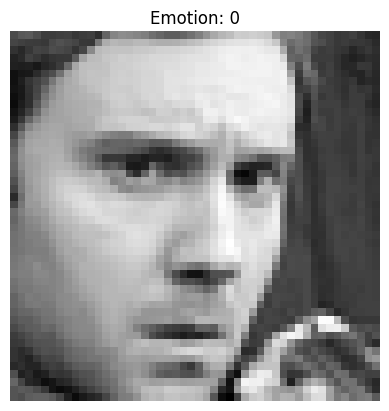

In [13]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = df_train['pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D
image = pixel_values.reshape(48, 48)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {df_train['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

- After resized 100x100:

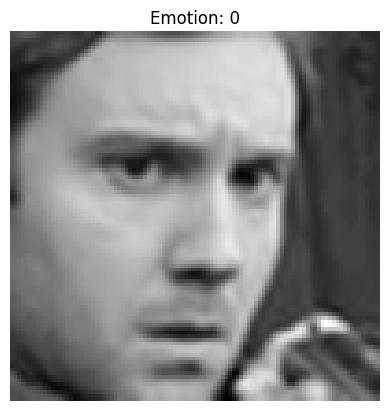

In [14]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # indeks baris yang diinginkan
pixels = processed_images_df_train['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D
pixel_values = np.array(pixels.split(), dtype=np.uint8)

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {processed_images_df_train['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()

## Augmantation

- Define augmentation function:

In [15]:
# Fungsi augmentasi
def augment_image(image):
    # Pipeline augmentasi menggunakan albumentations
    transform = A.Compose([
        A.RandomCrop(width=90, height=90),         # Random crop ukuran 80x80 dari gambar asli (100x100)
        A.HorizontalFlip(p=0.5),                   # Membalik gambar secara horizontal dengan probabilitas 50%
        A.Rotate(limit=20, p=0.5),                 # Memutar gambar dengan sudut hingga 20 derajat
        A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5),  # Jitter warna
        A.CoarseDropout(max_holes=4, max_height=5, max_width=5, p=0.5),  # Random masking
        A.Resize(100, 100),                        # Resize kembali menjadi ukuran 100x100
        # A.Normalize(mean=(0.5,), std=(0.5,)),      # Dibuatr normalize 0,1 agar bentuknya kembali semula kalo ini dihilangkan outputnya pecah, gak jadi ini setelah augmentasi
        ToTensorV2()                               # Ubah gambar menjadi tensor PyTorch
    ])
    
    augmented = transform(image=image)
    return augmented['image']

- Processing the augmentation:

In [16]:
# List untuk menyimpan hasil augmentasi
augmented_images = []
augmented_emotions = []

# Proses augmentasi untuk setiap gambar di dataframe asli
for i in tqdm(range(len(processed_images_df_train)), desc="Augmenting images"):
    # Ambil gambar dari dataframe dan ubah menjadi array 2D
    pixels = np.array(processed_images_df_train['resized_pixels'][i].split(), dtype=np.uint8).reshape(100, 100)
    
    # Augmentasi gambar
    augmented_image = augment_image(pixels)
    
    # Ubah tensor augmented_image kembali ke numpy array, lalu ubah jadi string lagi untuk disimpan di dataframe
    augmented_image_np = augmented_image.permute(1, 2, 0).numpy().flatten().tolist()  # Ubah ke list 1D
    augmented_image_str = ' '.join(map(str, augmented_image_np))  # Ubah list jadi string
    
    # Simpan gambar yang sudah di-augmentasi dan emosi ke list
    augmented_images.append(augmented_image_str)
    augmented_emotions.append(processed_images_df_train['emotion'][i])

# Masukkan hasil augmentasi ke dataframe baru
augmented_df_train = pd.DataFrame({
    'emotion': augmented_emotions,
    'resized_pixels': augmented_images
})

Augmenting images: 100%|██████████| 28709/28709 [03:27<00:00, 138.04it/s]


In [17]:
augmented_df_train

,emotion,resized_pixels
0,0,62 58 57 59 64 69 73 74 73 71 68 67 65 62 57 5...
1,0,172 171 167 157 143 129 119 117 118 122 126 12...
2,2,192 201 210 218 223 224 224 224 223 221 223 22...
3,4,29 29 31 31 28 24 24 28 31 29 23 20 19 18 17 1...
4,6,10 17 22 24 22 15 9 4 3 6 10 12 15 18 22 28 36...
...,...,...
28704,2,88 89 89 88 88 88 88 88 88 88 88 88 88 88 89 9...
28705,0,73 73 75 76 74 67 59 61 71 82 80 70 60 51 44 4...
28706,4,97 100 103 104 104 102 101 100 102 102 104 104...
28707,0,194 197 201 192 164 126 88 61 51 57 69 76 78 8...


- Visualize image after augmentation:

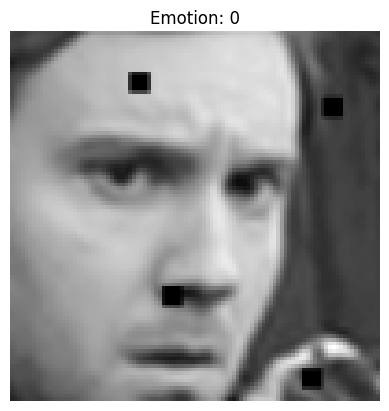

In [18]:
# Ambil data pixels dari baris yang diinginkan
row_index = 0  # Ganti dengan indeks baris yang diinginkan
pixels = augmented_df_train['resized_pixels'][row_index]

# Ubah string pixel menjadi array 1D (float)
pixel_values = np.array(pixels.split(), dtype=np.float32)

# Denormalisasi dari rentang [-1, 1] ke [0, 255]
# pixel_values = (pixel_values * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# Ubah array 1D menjadi array 2D (100x100)
image = pixel_values.reshape(100, 100)

# Ubah ke tipe data uint8 agar bisa ditampilkan sebagai gambar
image = image.astype(np.uint8)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.title(f"Emotion: {augmented_df_train['emotion'][row_index]}")
plt.axis('off')  # Hilangkan sumbu
plt.show()


- Append the new augmentation into original dataframe before the augmentation:

In [19]:
# Gabungkan dataframe asli dengan dataframe augmented
combined_df_train = pd.concat([processed_images_df_train, augmented_df_train], ignore_index=True)

# Tampilkan informasi jumlah data
print(f"Jumlah data setelah augmentasi: {len(combined_df_train)}")

# Tampilkan contoh baris dari dataframe gabungan
print(combined_df_train.head())

Jumlah data setelah augmentasi: 57418
  emotion                                     resized_pixels
0       0  69 71 77 84 86 84 80 72 64 59 57 57 57 58 61 6...
1       0  151 151 151 149 147 148 152 155 153 148 144 13...
2       2  230 232 227 205 173 154 153 166 178 175 154 13...
3       4  23 25 28 34 37 36 32 29 31 32 28 23 20 19 18 2...
4       6  6 3 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 ...


- Define function normalize pixel to [0,1] dividing by 255:

In [20]:
# Fungsi untuk normalisasi nilai piksel
def normalize_pixels(pixels):
    # Ubah string pixel menjadi array float
    pixel_values = np.array(pixels.split(), dtype=np.float32)
    
    # Bagi setiap nilai piksel dengan 255 untuk menormalisasi ke [0,1]
    normalized_pixel_values = pixel_values / 255.0
    
    # Ubah kembali array menjadi string agar sesuai dengan format dataframe
    return ' '.join(map(str, normalized_pixel_values))

- Proceeding the normalize to all row:

In [21]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
combined_df_train['resized_pixels'] = combined_df_train['resized_pixels'].progress_apply(normalize_pixels)

100%|██████████| 57418/57418 [10:02<00:00, 95.36it/s] 


In [22]:
# Terapkan normalisasi dengan progress bar
tqdm.pandas()  # Untuk menambahkan kemampuan progress bar pada pandas

# Normalisasi pada kolom 'resized_pixels' dengan progress bar
df_test['pixels'] = df_test['pixels'].progress_apply(normalize_pixels)

100%|██████████| 7178/7178 [00:30<00:00, 236.32it/s]


- Visualize datatable:

In [23]:
# Tampilkan informasi dataframe setelah normalisasi
combined_df_train.head()

,emotion,resized_pixels
0,0,0.27058825 0.2784314 0.3019608 0.32941177 0.33...
1,0,0.5921569 0.5921569 0.5921569 0.58431375 0.576...
2,2,0.9019608 0.9098039 0.8901961 0.8039216 0.6784...
3,4,0.09019608 0.09803922 0.10980392 0.13333334 0....
4,6,0.023529412 0.011764706 0.003921569 0.0 0.0 0....


emotion: Jika ini adalah label kelas, kamu bisa mengubahnya menjadi tipe data numerik menggunakan LabelEncoder dari scikit-learn:

In [24]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
combined_df_train['emotion'] = le.fit_transform(combined_df_train['emotion'])

resized_pixels: Jika kolom ini berisi string yang merepresentasikan array, kamu perlu mengubahnya menjadi array numpy. Misalnya:

In [25]:
import numpy as np

# Konversi string piksel menjadi array NumPy
combined_df_train['resized_pixels'] = combined_df_train['resized_pixels'].apply(
    lambda x: np.fromstring(x, sep=' ').astype(np.float32).reshape(100, 100)
)

In [26]:
# Pastikan semua entri memiliki ukuran 100x100
print(combined_df_train['resized_pixels'].apply(lambda x: x.shape == (100, 100)).all())

True


In [27]:
print(combined_df_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 57418 entries, 0 to 57417
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   emotion         57418 non-null  int64 
 1   resized_pixels  57418 non-null  object
dtypes: int64(1), object(1)
memory usage: 897.3+ KB
None


In [28]:
# Cek entri dengan ukuran 0 di kolom resized_pixels
empty_entries = combined_df_train[combined_df_train['resized_pixels'].apply(lambda x: len(x) == 0)]
print(empty_entries)

Empty DataFrame
Columns: [emotion, resized_pixels]
Index: []


In [30]:
# Tampilkan informasi dataframe setelah normalisasi
df_test.head()

,pixels
0,0.99607843 0.99607843 0.99607843 0.99607843 0....
1,0.6117647 0.72156864 0.7764706 0.7921569 0.8 0...
2,0.27058825 0.4627451 0.23921569 0.23529412 0.3...
3,0.8039216 0.79607844 0.9254902 0.6156863 0.325...
4,0.34117648 0.30980393 0.2901961 0.25882354 0.2...


## Mixup Augmentation

- Define function Mixup image and labels:

In [19]:
def mixup_images_labels(images, labels, alpha=0.2):
    """Menerapkan Mixup Augmentation pada dua gambar dan label.
    
    Args:
        images (tensor): Tensor gambar-gambar dengan shape (batch_size, channels, height, width).
        labels (tensor): Tensor one-hot encoded label dengan shape (batch_size, num_classes).
        alpha (float): Parameter distribusi Beta untuk campuran.

    Returns:
        mixed_images: Gambar campuran.
        mixed_labels: Label campuran.
    """
    # Ambil nilai lambda dari distribusi Beta
    lambda_val = np.random.beta(alpha, alpha)
    
    # Pilih dua indeks acak
    index = torch.randperm(images.size(0))
    
    # Gabungkan dua gambar
    mixed_images = lambda_val * images + (1 - lambda_val) * images[index, :]
    
    # Gabungkan label
    mixed_labels = lambda_val * labels + (1 - lambda_val) * labels[index, :]
    
    return mixed_images, mixed_labels


- Define function for data preparation before mixup: 

In [20]:
# Pastikan gambar dalam format tensor dan normalisasi ke [0, 1]
def prepare_images_labels(df):
    images = []
    labels = []

    for i in tqdm(range(len(df))):
        # Ambil pixel dan konversi ke array numpy
        pixels = np.array(df['resized_pixels'][i].split(), dtype=np.float32).reshape(100, 100) / 255.0
        
        # Tambahkan channel dimension untuk tensor (1 channel karena grayscale)
        images.append(pixels[np.newaxis, :, :])
        
        # Ambil label (ekspresi) dan ubah menjadi one-hot encoding
        label = df['emotion'][i]
        one_hot_label = np.zeros(8)  # Misal 8 kelas ekspresi
        one_hot_label[label] = 1
        labels.append(one_hot_label)

    # Ubah list ke tensor
    images = torch.tensor(np.array(images), dtype=torch.float32)
    labels = torch.tensor(np.array(labels), dtype=torch.float32)
    
    return images, labels

In [ ]:
# Persiapkan gambar dan label dari combined_df
images, labels = prepare_images_labels(combined_df)

- Processing Mixup Augmentation:

In [ ]:
# Batch size untuk Mixup Augmentation
batch_size = 64  # Batch size 64

# Acak gambar dan label untuk setiap batch
for i in tqdm(range(0, len(images), batch_size)):
    batch_images = images[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]
    
    # Terapkan Mixup Augmentation
    mixed_images, mixed_labels = mixup_images_labels(batch_images, batch_labels, alpha=0.2)

# (Selanjutnya, mixed_images dan mixed_labels dapat digunakan untuk training model)

In [ ]:
mixed_images

In [ ]:
mixed_labels

- Visualize the result of mixup augmented:

In [ ]:
mixed_image = mixed_images[0, 0]  # Ambil gambar pertama dari saluran pertama

# Ubah tensor ke numpy array
image = mixed_image.detach().numpy()  # Mengubah tensor menjadi numpy array

# Denormalisasi jika perlu, misal dari rentang [-1, 1] ke [0, 255]
image = (image * 0.5 + 0.5) * 255  # Skala ulang ke [0, 255]

# Pastikan untuk mengubah tipe data menjadi uint8
image = (image * 255).astype(np.uint8)

# Tampilkan gambar
plt.imshow(image, cmap='gray')
plt.axis('off')  # Hilangkan sumbu
plt.title("Mixed Image")
plt.show()


# MODELING

Konversi DataFrame ke Tensor:

In [31]:
class EmotionDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        image = torch.tensor(self.dataframe['resized_pixels'].iloc[idx], dtype=torch.float32).view(1, 100, 100)  # Jika gambar 100x100
        label = torch.tensor(self.dataframe['emotion'].iloc[idx], dtype=torch.long)
        return image, label


Membuat DataLoader:

In [54]:
# Inisialisasi dataset
train_dataset = EmotionDataset(combined_df_train)
test_dataset = EmotionDataset(df_test)

# Inisialisasi DataLoader
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

LBP circular

In [55]:
# Fungsi untuk mendapatkan intensitas piksel tetangga menggunakan interpolasi bilinear
def get_pixel_value(img, center, x, y):
    # Jika tetangga berada di dalam batas gambar
    if x >= 0 and x < img.shape[0] and y >= 0 and y < img.shape[1]:
        return img[int(x)][int(y)]
    else:
        return center

# Fungsi untuk menghitung Circular LBP pada piksel (x, y)
def lbp_calculated_pixel(img, x, y, radius, neighbors):
    center = img[x][y]
    values = []
    
    # Looping untuk mengambil nilai tetangga dalam pola melingkar
    for n in range(neighbors):
        theta = 2 * math.pi * n / neighbors  # Sudut
        x_n = x + radius * math.sin(theta)   # Koordinat tetangga dalam pola melingkar
        y_n = y + radius * math.cos(theta)
        neighbor_value = get_pixel_value(img, center, x_n, y_n)
        values.append(1 if neighbor_value >= center else 0)
    
    # Menghitung nilai biner LBP
    lbp_value = 0
    for i in range(len(values)):
        lbp_value += values[i] * (1 << i)  # 1 << i adalah 2^i
    
    return lbp_value

# Fungsi untuk menghitung Circular LBP untuk seluruh citra
def calculate_lbp_image(img, radius=1, neighbors=8):
    height, width = img.shape
    lbp_image = np.zeros((height, width), dtype=np.uint32)  # Mengubah tipe data ke uint32 untuk mendukung nilai besar
    
    for i in range(radius, height - radius):
        for j in range(radius, width - radius):
            lbp_image[i, j] = lbp_calculated_pixel(img, i, j, radius, neighbors)
    
    # Normalisasi jika diperlukan (mengembalikan nilai dalam rentang 0-255)
    lbp_image_normalized = np.uint8(lbp_image / lbp_image.max() * 255)
    
    return lbp_image_normalized

# Fungsi untuk menampilkan hasil
def show_output(original_img, lbp_img):
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    
    # Gambar asli (grayscale)
    axs[0].imshow(original_img, cmap='gray')
    axs[0].set_title('Original Grayscale Image')
    
    # Hasil LBP
    axs[1].imshow(lbp_img, cmap='gray')
    axs[1].set_title('Circular LBP Image')
    
    plt.show()

# Fungsi untuk ekstraksi fitur LBP dari batch gambar
def lbp_feature_extraction_batch(images, radius=3, neighbors=24):
    lbp_features = []
    for img in images:
        lbp_img = calculate_lbp_image(img.squeeze().cpu().numpy(), radius, neighbors)  # Ekstraksi LBP dari gambar
        lbp_hist, _ = np.histogram(lbp_img.ravel(), bins=np.arange(0, neighbors + 3), range=(0, neighbors + 2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= lbp_hist.sum()  # Normalisasi histogram
        lbp_features.append(lbp_hist)

    return np.array(lbp_features)
    
neighbors=24 # samakan dengan tabel dari referensi circular lbp ini yang optimal

# Definisikan ukuran fitur LBP
lbp_feature_size = neighbors + 2  # Misalnya 26 untuk 24 neighbors  

# Main function
# def lbp_feature_extraction(image):
#     # Membaca citra
#     # image_file = '../src/lenna.jpg'
#     image_file = image
#     img_bgr = cv2.imread(image_file)
#     img_gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
    
#     # Hitung LBP dengan radius 3 dan 24 tetangga
#     lbp_img = calculate_lbp_image(img_gray, radius=3, neighbors=24)
    
#     # Tampilkan hasilnya
#     show_output(img_gray, lbp_img)

#     return lbp_img

# if __name__ == "__main__":
#     lbp_img = lbp_feature_extraction()


Mengonversi Output LBP menjadi Vektor dan Menghubungkan ke FC Layer:

In [56]:
# Channel Attention Module
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        # MLP
        self.fc1 = nn.Conv2d(in_channels, in_channels // ratio, kernel_size=1, bias=False)
        self.fc2 = nn.Conv2d(in_channels // ratio, in_channels, kernel_size=1, bias=False)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = self.fc2(self.relu(self.fc1(self.avg_pool(x))))
        max_out = self.fc2(self.relu(self.fc1(self.max_pool(x))))
        out = avg_out + max_out
        return self.sigmoid(out)

# Spatial Attention Module
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=kernel_size, padding=kernel_size//2, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        x = torch.cat([avg_out, max_out], dim=1)
        x = self.conv1(x)
        return self.sigmoid(x)

# CBAM Module (Channel + Spatial Attention)
class CBAM(nn.Module):
    def __init__(self, in_channels, ratio=16, kernel_size=7):
        super(CBAM, self).__init__()
        self.channel_attention = ChannelAttention(in_channels, ratio)
        self.spatial_attention = SpatialAttention(kernel_size)

    def forward(self, x):
        x = x * self.channel_attention(x)
        x = x * self.spatial_attention(x)
        return x


In [57]:
class ResNet18_CBAM(nn.Module):
    def __init__(self, n_classes):
        super(ResNet18_CBAM, self).__init__()
        
        self.dropout_percentage = 0.5
        self.relu = nn.ReLU()
        
        # BLOCK-1 (starting block) input=(224x224) output=(56x56)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(7,7), stride=(2,2), padding=(3,3))
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.maxpool1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(1,1))
        
        # CBAM after block1
        self.cbam1 = CBAM(64)

        # BLOCK-2 (1) input=(56x56) output = (56x56)
        self.conv2_1_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_1 = nn.BatchNorm2d(64)
        self.conv2_1_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_1_2 = nn.BatchNorm2d(64)
        self.dropout2_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-2 (2)
        self.conv2_2_1 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_1 = nn.BatchNorm2d(64)
        self.conv2_2_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm2_2_2 = nn.BatchNorm2d(64)
        self.dropout2_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block2
        self.cbam2 = CBAM(64)
        
        # BLOCK-3 (1) input=(56x56) output = (28x28)
        self.conv3_1_1 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm3_1_1 = nn.BatchNorm2d(128)
        self.conv3_1_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_1_2 = nn.BatchNorm2d(128)
        self.concat_adjust_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout3_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-3 (2)
        self.conv3_2_1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_1 = nn.BatchNorm2d(128)
        self.conv3_2_2 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm3_2_2 = nn.BatchNorm2d(128)
        self.dropout3_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block3
        self.cbam3 = CBAM(128)

        # BLOCK-4 (1) input=(28x28) output = (14x14)
        self.conv4_1_1 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm4_1_1 = nn.BatchNorm2d(256)
        self.conv4_1_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_1_2 = nn.BatchNorm2d(256)
        self.concat_adjust_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout4_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-4 (2)
        self.conv4_2_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_1 = nn.BatchNorm2d(256)
        self.conv4_2_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm4_2_2 = nn.BatchNorm2d(256)
        self.dropout4_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block4
        self.cbam4 = CBAM(256)

        # BLOCK-5 (1) input=(14x14) output = (7x7)
        self.conv5_1_1 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(3,3), stride=(2,2), padding=(1,1))
        self.batchnorm5_1_1 = nn.BatchNorm2d(512)
        self.conv5_1_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_1_2 = nn.BatchNorm2d(512)
        self.concat_adjust_5 = nn.Conv2d(in_channels=256, out_channels=512, kernel_size=(1,1), stride=(2,2), padding=(0,0))
        self.dropout5_1 = nn.Dropout(p=self.dropout_percentage)
        # BLOCK-5 (2)
        self.conv5_2_1 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_1 = nn.BatchNorm2d(512)
        self.conv5_2_2 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=(3,3), stride=(1,1), padding=(1,1))
        self.batchnorm5_2_2 = nn.BatchNorm2d(512)
        self.dropout5_2 = nn.Dropout(p=self.dropout_percentage)
        
        # CBAM after block5
        self.cbam5 = CBAM(512)
        
        # Final Block input=(7x7) 
        # self.avgpool = nn.AvgPool2d(kernel_size=(7, 7), stride=(7, 7))  # Mengubah output menjadi (512, 1, 1)
        self.avgpool = nn.AvgPool2d(kernel_size=(4, 4), stride=(4, 4))  # Output akan menjadi (512, 1, 1)
        self.fc = nn.Linear(in_features=1 * 1 * 512, out_features=1000)  # 512 dari avgpool
        self.out = nn.Linear(in_features=1000, out_features=n_classes)  # n_classes sesuai dengan jumlah kelas
        # END

    def forward(self, x):
        # block 1 --> Starting block
        x = self.relu(self.batchnorm1(self.conv1(x)))
        op1 = self.maxpool1(x)
        op1 = self.cbam1(op1)
        # print(f"Output after Block 1: {op1.shape}")  # Cek ukuran output
        
        # block2 - 1
        x = self.relu(self.batchnorm2_1_1(self.conv2_1_1(op1)))    # conv2_1 
        x = self.batchnorm2_1_2(self.conv2_1_2(x))                 # conv2_1
        x = self.dropout2_1(x)
        # block2 - Adjust - No adjust in this layer as dimensions are already same
        # block2 - Concatenate 1
        op2_1 = self.relu(x + op1)
        # block2 - 2
        x = self.relu(self.batchnorm2_2_1(self.conv2_2_1(op2_1)))  # conv2_2 
        x = self.batchnorm2_2_2(self.conv2_2_2(x))                 # conv2_2
        x = self.dropout2_2(x)
        # op - block2
        op2 = self.relu(x + op2_1)
        op2 = self.cbam2(op2)
        # print(f"Output after Block 2: {op2.shape}")  # Cek ukuran output
        
        # block3 - 1[Convolution block]
        x = self.relu(self.batchnorm3_1_1(self.conv3_1_1(op2)))    # conv3_1
        x = self.batchnorm3_1_2(self.conv3_1_2(x))                 # conv3_1
        x = self.dropout3_1(x)
        # block3 - Adjust
        op2 = self.concat_adjust_3(op2) # SKIP CONNECTION
        # block3 - Concatenate 1
        op3_1 = self.relu(x + op2)
        # block3 - 2[Identity Block]
        x = self.relu(self.batchnorm3_2_1(self.conv3_2_1(op3_1)))  # conv3_2
        x = self.batchnorm3_2_2(self.conv3_2_2(x))                 # conv3_2 
        x = self.dropout3_2(x)
        # op - block3
        op3 = self.relu(x + op3_1)
        op3 = self.cbam3(op3)
        # print(f"Output after Block 3: {op3.shape}")  # Cek ukuran output

        # block4 - 1[Convolition block]
        x = self.relu(self.batchnorm4_1_1(self.conv4_1_1(op3)))    # conv4_1
        x = self.batchnorm4_1_2(self.conv4_1_2(x))                 # conv4_1
        x = self.dropout4_1(x)
        # block4 - Adjust
        op3 = self.concat_adjust_4(op3) # SKIP CONNECTION
        # block4 - Concatenate 1
        op4_1 = self.relu(x + op3)
        # block4 - 2[Identity Block]
        x = self.relu(self.batchnorm4_2_1(self.conv4_2_1(op4_1)))  # conv4_2
        x = self.batchnorm4_2_2(self.conv4_2_2(x))                 # conv4_2
        x = self.dropout4_2(x)
        # op - block4
        op4 = self.relu(x + op4_1)
        op4 = self.cbam4(op4)
        # print(f"Output after Block 4: {op4.shape}")  # Cek ukuran output

        # block5 - 1[Convolution Block]
        x = self.relu(self.batchnorm5_1_1(self.conv5_1_1(op4)))    # conv5_1
        x = self.batchnorm5_1_2(self.conv5_1_2(x))                 # conv5_1
        x = self.dropout5_1(x)
        # block5 - Adjust
        op4 = self.concat_adjust_5(op4) # SKIP CONNECTION
        # block5 - Concatenate 1
        op5_1 = self.relu(x + op4)
        # block5 - 2[Identity Block]
        x = self.relu(self.batchnorm5_2_1(self.conv5_2_1(op5_1)))  # conv5_2
        x = self.batchnorm5_2_2(self.conv5_2_2(x))                 # conv5_2
        x = self.dropout5_2(x)
        # op - block5
        op5 = self.relu(x + op5_1)
        op5 = self.cbam5(op5)
        # print(f"Output after Block 5: {op5.shape}")  # Cek ukuran output
        
        # final operations
        x = self.avgpool(op5)
        # print(f"Shape after avgpool: {x.shape}")
        x = torch.flatten(x, 1)
        # print(f"Shape after flatten: {x.shape}")
        xfeatures = self.fc(x)
        # print(f"Output after fc: {x.shape}")  # Cek ukuran output
        # x = self.out(x) # Jangan panggil self.out
        # print(f"Output self.out: {x.shape}")  # Cek ukuran output
        return xfeatures


In [58]:
class CombinedModel(nn.Module):
    def __init__(self, n_classes, lbp_feature_size):
        super(CombinedModel, self).__init__()
        self.resnet = ResNet18_CBAM(n_classes)
        self.fc_lbp = nn.Linear(lbp_feature_size, 128)  # Ubah lbp_feature_size sesuai ukuran LBP
        self.fc_combined = nn.Linear(128 + 1000, n_classes)  # Gabungkan output LBP dan ResNet

    def forward(self, x):
        # Ekstraksi fitur LBP
        lbp_features = lbp_feature_extraction_batch(x)  # Ekstrak fitur LBP
        lbp_features = torch.from_numpy(lbp_features).float().to(x.device)  # Konversi ke tensor dan pindahkan ke device
        lbp_features = lbp_features.view(lbp_features.size(0), -1)  # Flatten jika perlu
        # print(f"LBP feature size: {lbp_features.shape}")
        
        # Proses fitur LBP
        lbp_features = self.fc_lbp(lbp_features)
        # print(f"Processed LBP feature size: {lbp_features.shape}")
        
        # Proses melalui ResNet (output fitur sebelum klasifikasi akhir)
        resnet_output = self.resnet(x)  # Output [32,1000]
        # print(f"ResNet output size: {resnet_output.shape}")
        
        # Gabungkan output LBP dan ResNet
        combined = torch.cat((lbp_features, resnet_output), dim=1)  # [32,1128]
        # print(f"Combined feature size: {combined.shape}")
        
        # Proses melalui fully connected layer
        output = self.fc_combined(combined)  # [32,7]
        # print(f"Output after fc_combined: {output.shape}")
        
        return output

Training Model dengan Batch Processing:


In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


memastikan tidak ada diluar rentang 0-6 pada label:


In [49]:
labels = torch.tensor(combined_df_train['emotion'].values)
print(labels.unique())  # Pastikan label tidak ada yang out-of-range

tensor([0, 1, 2, 3, 4, 5, 6])


In [39]:
# device = torch.device('cpu')
# model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size).to(device)

In [50]:
device

device(type='cuda')

In [60]:
from tqdm import tqdm  # Import tqdm untuk progress bar

# Inisialisasi model dan optimasi
model = CombinedModel(n_classes=7, lbp_feature_size=lbp_feature_size).to(device)  # Sesuaikan n_classes dengan jumlah kelas dataset
criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
optimizer = torch.optim.SGD(model.parameters(), lr=0.9, momentum=0.1, weight_decay=0.0001)

# Training loop dengan progress bar
epochs = 10
for epoch in range(epochs):
    running_loss = 0.0
    model.train()  # Set model ke training mode
    
    # Tambahkan progress bar pada iterasi data loader
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")
    
    for images, labels in progress_bar:
        images = images.to(device)
        labels = labels.to(device)  # Pastikan label juga dipindahkan ke device yang sama
        
        # Forward pass
        outputs = model(images)
        
        # Hitung loss
        loss = criterion(outputs, labels)
        
        # Backward pass dan optimasi
        optimizer.zero_grad()  # Reset gradien
        loss.backward()  # Hitung gradien
        optimizer.step()  # Perbarui parameter
        
        running_loss += loss.item()
        
        # Update progress bar dengan info loss
        progress_bar.set_postfix({'Loss': loss.item()})
    
    # Hitung rata-rata loss per epoch
    average_loss = running_loss / len(train_loader)
    print(f"Epoch {epoch + 1}, Average Loss: {average_loss:.4f}")

print("Training selesai.")


Epoch 1/10:  34%|███▍      | 306/898 [1:48:54<3:30:42, 21.36s/it, Loss=1.82]


KeyboardInterrupt: 

In [ ]:
 selesai.")


In [ ]:
# Contoh mengambil batch pertama dari train_loader
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Print ukuran dan nilai dari label
print(f"Ukuran label: {labels.shape}")
print(f"Label batch pertama: {labels}")


In [ ]:
torch.cuda.empty_cache()  # Bersihkan cache CUDA